https://data.stats.gov.cn/

注：1.铁路运输数据来源于中国国家铁路集团有限公司、公路水路运输数据来源于交通运输部，民航运输数据来源于中国民用航空局。																																																																																													
　　　2.自2020年1月起，交通运输部根据2019道路货物运输量专项调查调整月度公路货物运输量、公路货物运输周转量统计口径，同比增速按照调整后可比口径计算。																																																																																													
　　　3.自2020年1月起，水路运输（海洋）统计方式改变，由行业主管部门报送调整为企业联网直报，2020年以可比口径计算增速。																																																																																													
　　　4.从2015年1月起，铁路客运统计口径发生变化，由按售票数统计改为按乘车人数统计。																																																																																													
　　　5.根据2013年开展的交通运输业经济统计专项调查，我部对公路水路运输量的统计口径和推算方案进行了调整。有关2014年月度公路水路客货运输量均按新方案推算并进行更新。																																																																																													
数据来源：国家统计局																																																																																													
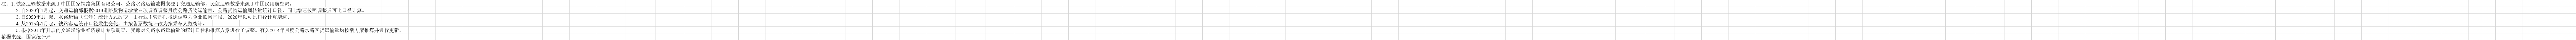

In [1]:
import numpy as np
from sklearn.utils import resample

In [2]:
class Node:
    """
    Each node in neural networks will have these attributes and methods
    """
    def __init__(self,inputs=[]):
        """
        if the node is operator of "ax + b" , the inputs will be x node , and the outputs
        of this is its successors , and the value is *ax + b*
        """
        self.inputs = inputs 
        self.outputs = []
        self.value = None
        self.gradients = { }
        
        for node in self.inputs:
            node.outputs.append(self) # bulid a connection relationship
            
    def forward(self):
        """Forward propogation
        
        compute the output value based on input nodes and store the value
        into *self.value*
        
        """
        # 虚类
        # 如果一个对象是它的子类，就必须要重新实现这个方法
        raise NotImplemented
        
    def backward(self):
        """Backward propogation
        
        compute the gradient of each input node and store the value
        into *self.gradients*
        
        """
        # 虚类
        # 如果一个对象是它的子类，就必须要重新实现这个方法       
        raise NotImplemented

In [3]:
class Input(Node):
    def __init__(self, name=''):
        Node.__init__(self, inputs=[])
        self.name = name
    
    def forward(self, value=None):
        if value is not None:
            self.value = value
        
    def backward(self):
        self.gradients = {}
        
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost
    
    def __repr__(self):
        return 'Input Node: {}'.format(self.name)

In [4]:
class Linear(Node):
    def __init__(self, nodes, weights, bias):
        self.w_node = weights
        self.x_node = nodes
        self.b_node = bias
        Node.__init__(self, inputs=[nodes, weights, bias])
    
    def forward(self): 
        """compute the wx + b using numpy"""
        self.value = np.dot(self.x_node.value, self.w_node.value) + self.b_node.value
        
    
    def backward(self):
        
        for node in self.outputs:
            #gradient_of_loss_of_this_output_node = node.gradient[self]
            grad_cost = node.gradients[self]
            
            self.gradients[self.w_node] = np.dot(self.x_node.value.T, grad_cost) # loss对w的偏导 = loss对self的偏导 * self对w的偏导
            self.gradients[self.b_node] = np.sum(grad_cost * 1, axis=0, keepdims=False)
            self.gradients[self.x_node] = np.dot(grad_cost, self.w_node.value.T)

In [5]:
class Sigmoid(Node):
    def __init__(self, node):
        Node.__init__(self, [node])
        self.x_node = node
    
    def _sigmoid(self, x):
        return 1. / (1 + np.exp(-1 * x))
    
    def forward(self):
        self.value = self._sigmoid(self.x_node.value)
    
    def backward(self):
        y = self.value
        
        self.partial = y * (1 - y)
        
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self.x_node] = grad_cost * self.partial

In [6]:
class MSE(Node):
    def __init__(self, y_true, y_hat):
        self.y_true_node = y_true
        self.y_hat_node = y_hat
        Node.__init__(self, inputs=[y_true, y_hat])
    
    def forward(self):
        y_true_flatten = self.y_true_node.value.reshape(-1, 1)
        y_hat_flatten = self.y_hat_node.value.reshape(-1, 1)
        
        self.diff = y_true_flatten - y_hat_flatten
        
        self.value = np.mean(self.diff**2)
        
    def backward(self):
        n = self.y_hat_node.value.shape[0]
        
        self.gradients[self.y_true_node] = (2 / n) * self.diff
        self.gradients[self.y_hat_node] =  (-2 / n) * self.diff

In [7]:
def topological_sort(data_with_value):
    feed_dict = data_with_value 
    input_nodes = [n for n in feed_dict.keys()]

    G = {}
    nodes = [n for n in input_nodes]
    while len(nodes) > 0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in': set(), 'out': set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in': set(), 'out': set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)

    L = []
    S = set(input_nodes)
    while len(S) > 0:
        n = S.pop()

        if isinstance(n, Input):
            n.value = feed_dict[n]
            ## if n is Input Node, set n'value as 
            ## feed_dict[n]
            ## else, n's value is caculate as its
            ## inbounds

        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            # if no other incoming edges add to S
            if len(G[m]['in']) == 0:
                S.add(m)
    return L

def training_one_batch(topological_sorted_graph):
    # graph 是经过拓扑排序之后的 一个list
    for node in topological_sorted_graph:
        node.forward()
        
    for node in topological_sorted_graph[::-1]:
        node.backward()

def sgd_update(trainable_nodes, learning_rate=1e-2):
    for t in trainable_nodes:
        t.value += -1 * learning_rate * t.gradients[t]
        
def run(dictionary):
    return topological_sort(dictionary)

In [8]:
import pandas as pd
data = pd.read_csv('国家统计局月度数据统计.csv',encoding='gbk')
print('Shape:',data.shape)
print('before fillna:',data.isna().sum().sum())
data.fillna(0,inplace=True)
print('after fillna:',data.isna().sum().sum())
data.head()

Shape: (92, 21)
before fillna: 30
after fillna: 0


,时间,客运量当期值(万人),客运量累计值(万人),客运量同比增长(%),客运量累计增长(%),铁路客运量当期值(万人),铁路客运量累计值(万人),铁路客运量同比增长(%),铁路客运量累计增长(%),公路客运量当期值(万人),...,公路客运量同比增长(%),公路客运量累计增长(%),水运客运量当期值(万人),水运客运量累计值(万人),水运客运量同比增长(%),水运客运量累计增长(%),民航客运量当期值(万人),民航客运量累计值(万人),民航客运量同比增长(%),民航客运量累计增长(%)
0,2013年1月,332321.0,332321,4.0,4.0,18757,18757,16.5,16.5,309398.0,...,3.4,3.4,1599.0,1599,-5.4,-5.4,2567,2567,0.0,0.0
1,2013年2月,340019.0,672346,7.8,5.9,14044,32801,2.3,10.0,321130.0,...,8.0,5.7,2058.0,3657,7.2,1.3,2787,5361,18.5,9.0
2,2013年3月,323931.0,996697,6.3,6.1,16854,50066,16.6,13.1,302412.0,...,5.7,5.7,1787.0,5445,1.5,1.4,2878,8246,14.9,11.1
3,2013年4月,323560.0,1320263,5.9,6.1,17502,67568,6.4,11.3,301245.0,...,5.9,5.8,1964.0,7409,1.8,1.5,2849,11102,9.2,10.7
4,2013年5月,327183.0,1647426,4.8,5.8,16232,83799,9.1,10.8,305909.0,...,4.6,5.5,2187.0,9596,-2.1,0.7,2855,13937,12.1,10.6


In [9]:
X_names = data['时间']
Y_names = '客运量当期值(万人)'
X_ = data[[i for i in data.columns if i not in ['时间','客运量当期值(万人)']]]
Y_ = data['客运量当期值(万人)'].values

X_ = (X_ - np.mean(X_ , axis=0)) / np.std(X_ , axis = 0)
print(X_.shape)

(92, 19)


In [10]:
n_features = X_.shape[1]
n_hidden = 10
n_hidden_2 = 10

W1_ = np.random.randn(n_features , n_hidden)
b1_ = np.zeros(n_hidden)

W2_ = np.random.randn(n_hidden,1)
b2_ = np.zeros(1)

X, Y = Input(name='X'), Input(name='y')  # tensorflow -> placeholder
W1, b1 = Input(name='W1'), Input(name='b1')
W2, b2 = Input(name='W2'), Input(name='b2')

linear_output = Linear(X, W1, b1)
sigmoid_output = Sigmoid(linear_output)
Yhat = Linear(sigmoid_output, W2, b2)
loss = MSE(Y, Yhat)

In [14]:
input_node_with_value = { # -> feed_dict
    X:X_,
    Y:Y_,
    W1:W1_,
    W2:W2_,
    b1:b1_,
    b2:b2_
}
graph = topological_sort(input_node_with_value)
graph

[Input Node: b1,
 Input Node: b2,
 Input Node: W1,
 Input Node: X,
 Input Node: y,
 Input Node: W2,

In [16]:
epoch_s = []
losses = []
epochs = 50000

batch_size = 64
steps_per_epoch = X_.shape[0] // batch_size
learning_rate = 0.2

for i in range(epochs):
    loss = 0
    
    for batch in range(steps_per_epoch):

        X_batch, Y_batch = resample(X_, Y_, n_samples=batch_size)
        
        X.value = X_batch
        Y.value = Y_batch
        
        
        training_one_batch(graph)
        sgd_update(trainable_nodes=[W1, W2, b1, b2], learning_rate=learning_rate)
        
        loss += graph[-1].value
        
    if i % 100 == 0:
        print('Epoch: {}, loss = {:.3f}'.format(i+1, loss/steps_per_epoch))
        epoch_s.append(i+1)
        losses.append(loss)

Epoch: 1, loss = 32317350740.208
Epoch: 101, loss = 3491219865.816


F:\Anaconda\envs\ml\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


Epoch: 201, loss = 3893867629.972
Epoch: 301, loss = 4521840564.676
Epoch: 401, loss = 2840230382.882
Epoch: 501, loss = 3741530551.100
Epoch: 601, loss = 2215658123.313
Epoch: 701, loss = 3602820978.735
Epoch: 801, loss = 2714255189.984
Epoch: 901, loss = 2096108228.843
Epoch: 1001, loss = 1819368093.180
Epoch: 1101, loss = 3487000425.325
Epoch: 1201, loss = 1641304246.971
Epoch: 1301, loss = 2821481277.962
Epoch: 1401, loss = 3094768559.187
Epoch: 1501, loss = 3633614602.786
Epoch: 1601, loss = 4153832644.643
Epoch: 1701, loss = 5719797318.681
Epoch: 1801, loss = 2010029676.474
Epoch: 1901, loss = 1811656227.172
Epoch: 2001, loss = 3081952610.707
Epoch: 2101, loss = 1994891355.536
Epoch: 2201, loss = 4015735154.782
Epoch: 2301, loss = 3489114296.490
Epoch: 2401, loss = 2075317239.084
Epoch: 2501, loss = 4480022604.760
Epoch: 2601, loss = 2607793610.335
Epoch: 2701, loss = 2491657994.857
Epoch: 2801, loss = 2924010213.622
Epoch: 2901, loss = 2719274708.366
Epoch: 3001, loss = 29120574

Epoch: 23401, loss = 5100253440.749
Epoch: 23501, loss = 9469735764.825
Epoch: 23601, loss = 2568679933.256
Epoch: 23701, loss = 2286651498.561
Epoch: 23801, loss = 3690716671.970
Epoch: 23901, loss = 3882786050.782
Epoch: 24001, loss = 1910844311.541
Epoch: 24101, loss = 2450829886.219
Epoch: 24201, loss = 2702915835.566
Epoch: 24301, loss = 4090586042.274
Epoch: 24401, loss = 3111759477.907
Epoch: 24501, loss = 2147628765.493
Epoch: 24601, loss = 4687200534.361
Epoch: 24701, loss = 2249296672.436
Epoch: 24801, loss = 3130668518.870
Epoch: 24901, loss = 3504631145.423
Epoch: 25001, loss = 3281243130.222
Epoch: 25101, loss = 4119320880.395
Epoch: 25201, loss = 2106828295.683
Epoch: 25301, loss = 2993948367.309
Epoch: 25401, loss = 4442587124.603
Epoch: 25501, loss = 2604112135.761
Epoch: 25601, loss = 1857741652.696
Epoch: 25701, loss = 2606574062.344
Epoch: 25801, loss = 1047400551.120
Epoch: 25901, loss = 3022057160.586
Epoch: 26001, loss = 2826658569.166
Epoch: 26101, loss = 2570493

Epoch: 46301, loss = 2036425294.211
Epoch: 46401, loss = 3239398135.694
Epoch: 46501, loss = 2612456249.697
Epoch: 46601, loss = 3855133880.259
Epoch: 46701, loss = 4089974921.900
Epoch: 46801, loss = 3108118384.490
Epoch: 46901, loss = 1985937220.131
Epoch: 47001, loss = 5301414977.943
Epoch: 47101, loss = 2625321567.183
Epoch: 47201, loss = 3255835677.018
Epoch: 47301, loss = 3955896365.590
Epoch: 47401, loss = 2727266321.350
Epoch: 47501, loss = 3362224851.080
Epoch: 47601, loss = 4279731079.679
Epoch: 47701, loss = 3497816516.688
Epoch: 47801, loss = 4950750467.318
Epoch: 47901, loss = 2769408881.443
Epoch: 48001, loss = 2866151665.668
Epoch: 48101, loss = 4726276330.043
Epoch: 48201, loss = 2458346539.346
Epoch: 48301, loss = 1783663656.972
Epoch: 48401, loss = 5350878859.784
Epoch: 48501, loss = 4418187475.171
Epoch: 48601, loss = 1000241028.492
Epoch: 48701, loss = 2418583276.169
Epoch: 48801, loss = 2612565547.541
Epoch: 48901, loss = 3067418583.591
Epoch: 49001, loss = 3625433

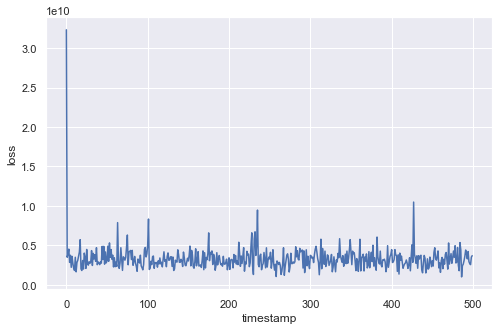

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline

sns.set()
plt.figure(figsize=(8,5))
plt.xlabel('timestamp')
plt.ylabel('loss')
plt.plot(range(len(losses)),losses)